In [1]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.models import Model
from google.colab import files

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [4]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

class_names = ['avião', 'carro', 'pássaro', 'gato', 'cervo', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

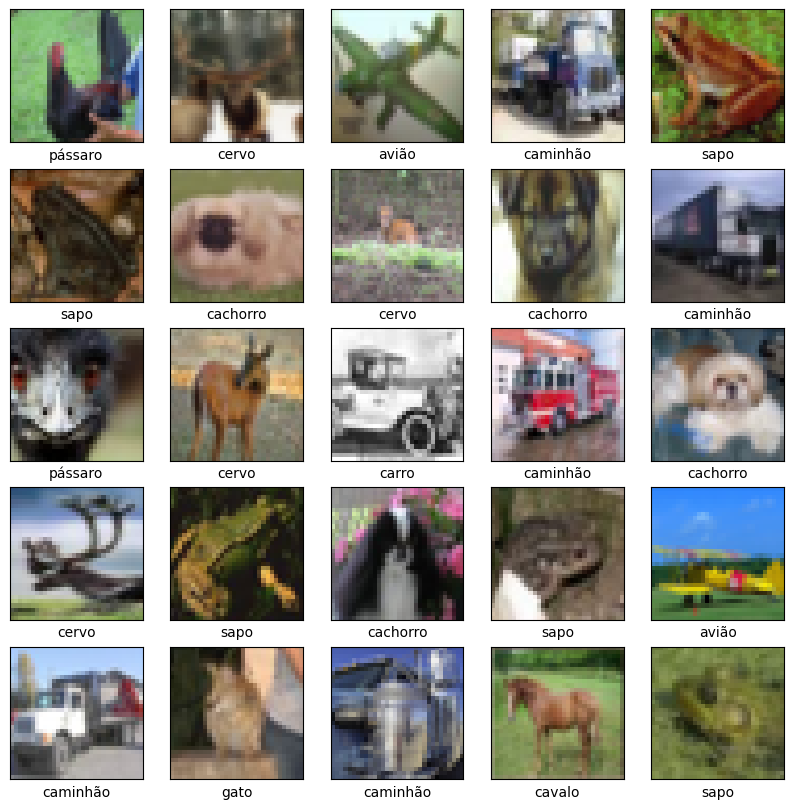

In [5]:
plt.figure(figsize=(10,10))
for i in range(25, 50):
    plt.subplot(5, 5, i-24)  # Ajuste para o subplot começar do 1 novamente
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])
    plt.xlabel(class_names[int(y_test[i].argmax())])
plt.show()

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

In [18]:
model = tf.keras.Sequential([
    data_augmentation,

    tf.keras.layers.Conv2D(64, (2,2), input_shape=(32, 32, 3), padding='valid', kernel_initializer='he_normal', bias_initializer='zeros'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(128, (3,3), padding='valid', kernel_regularizer=tf.keras.regularizers.l2(), kernel_initializer='he_normal', bias_initializer='zeros'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    #tf.keras.layers.Dropout(0.3),

    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (2,2), padding='valid', kernel_initializer='he_normal', bias_initializer='zeros'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    #tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(256, (1,1), padding='valid', kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dropout(0.5),#ajt 0.6

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.5),#ajt 0.6

    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2()),

    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_normal')


])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    clipnorm=1.0,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
]

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks= callbacks
    )

Epoch 1/100
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1848 - loss: 6.8794
Epoch 1: val_loss improved from inf to 3.32732, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.1851 - loss: 6.8602 - val_accuracy: 0.2577 - val_loss: 3.3273 - learning_rate: 0.0010
Epoch 2/100
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2916 - loss: 2.9622
Epoch 2: val_loss improved from 3.32732 to 2.66771, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.2917 - loss: 2.9609 - val_accuracy: 0.3675 - val_loss: 2.6677 - learning_rate: 0.0010
Epoch 3/100
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3171 - loss: 2.5742
Epoch 3: val_loss improved from 2.66771 to 2.30574, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.3171 - loss: 2.5738 - val_accuracy: 0.4039 - val_loss: 2.3057 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - ac

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6991 - loss: 1.0723
Test Loss: 1.0646
Test Accuracy: 0.6958
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


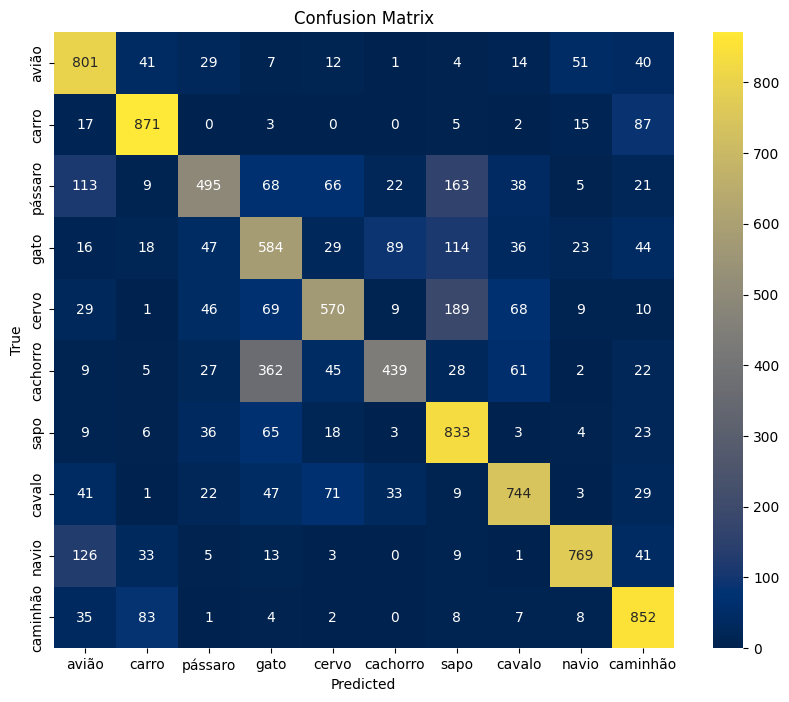

In [21]:

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='cividis', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

       avião       0.67      0.80      0.73      1000
       carro       0.82      0.87      0.84      1000
     pássaro       0.70      0.49      0.58      1000
        gato       0.48      0.58      0.53      1000
       cervo       0.70      0.57      0.63      1000
    cachorro       0.74      0.44      0.55      1000
        sapo       0.61      0.83      0.71      1000
      cavalo       0.76      0.74      0.75      1000
       navio       0.87      0.77      0.81      1000
    caminhão       0.73      0.85      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.69     10000
weighted avg       0.71      0.70      0.69     10000



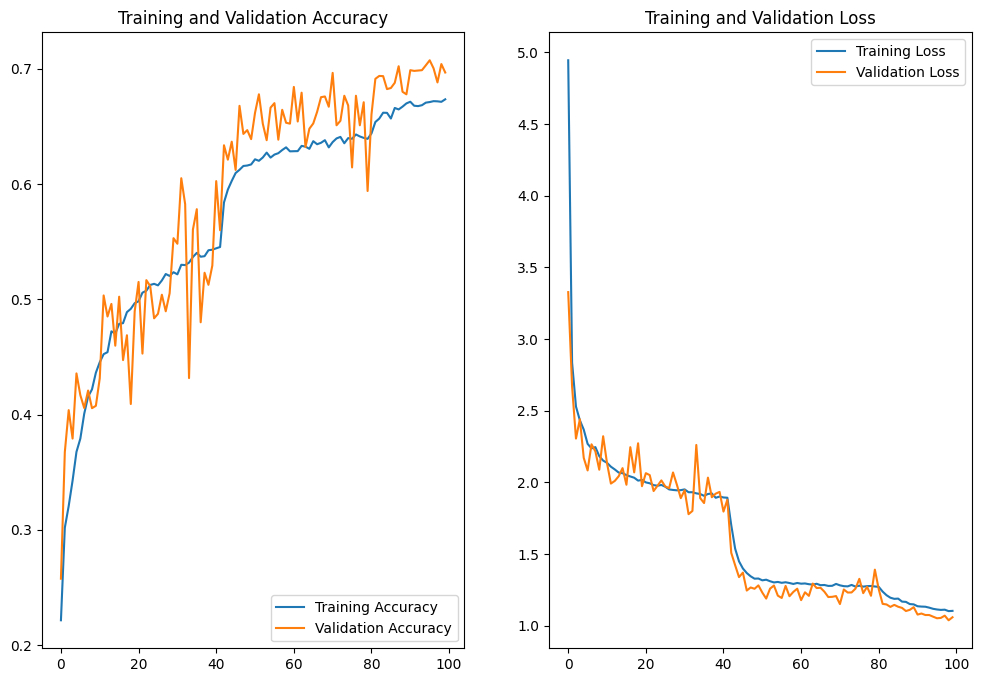

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


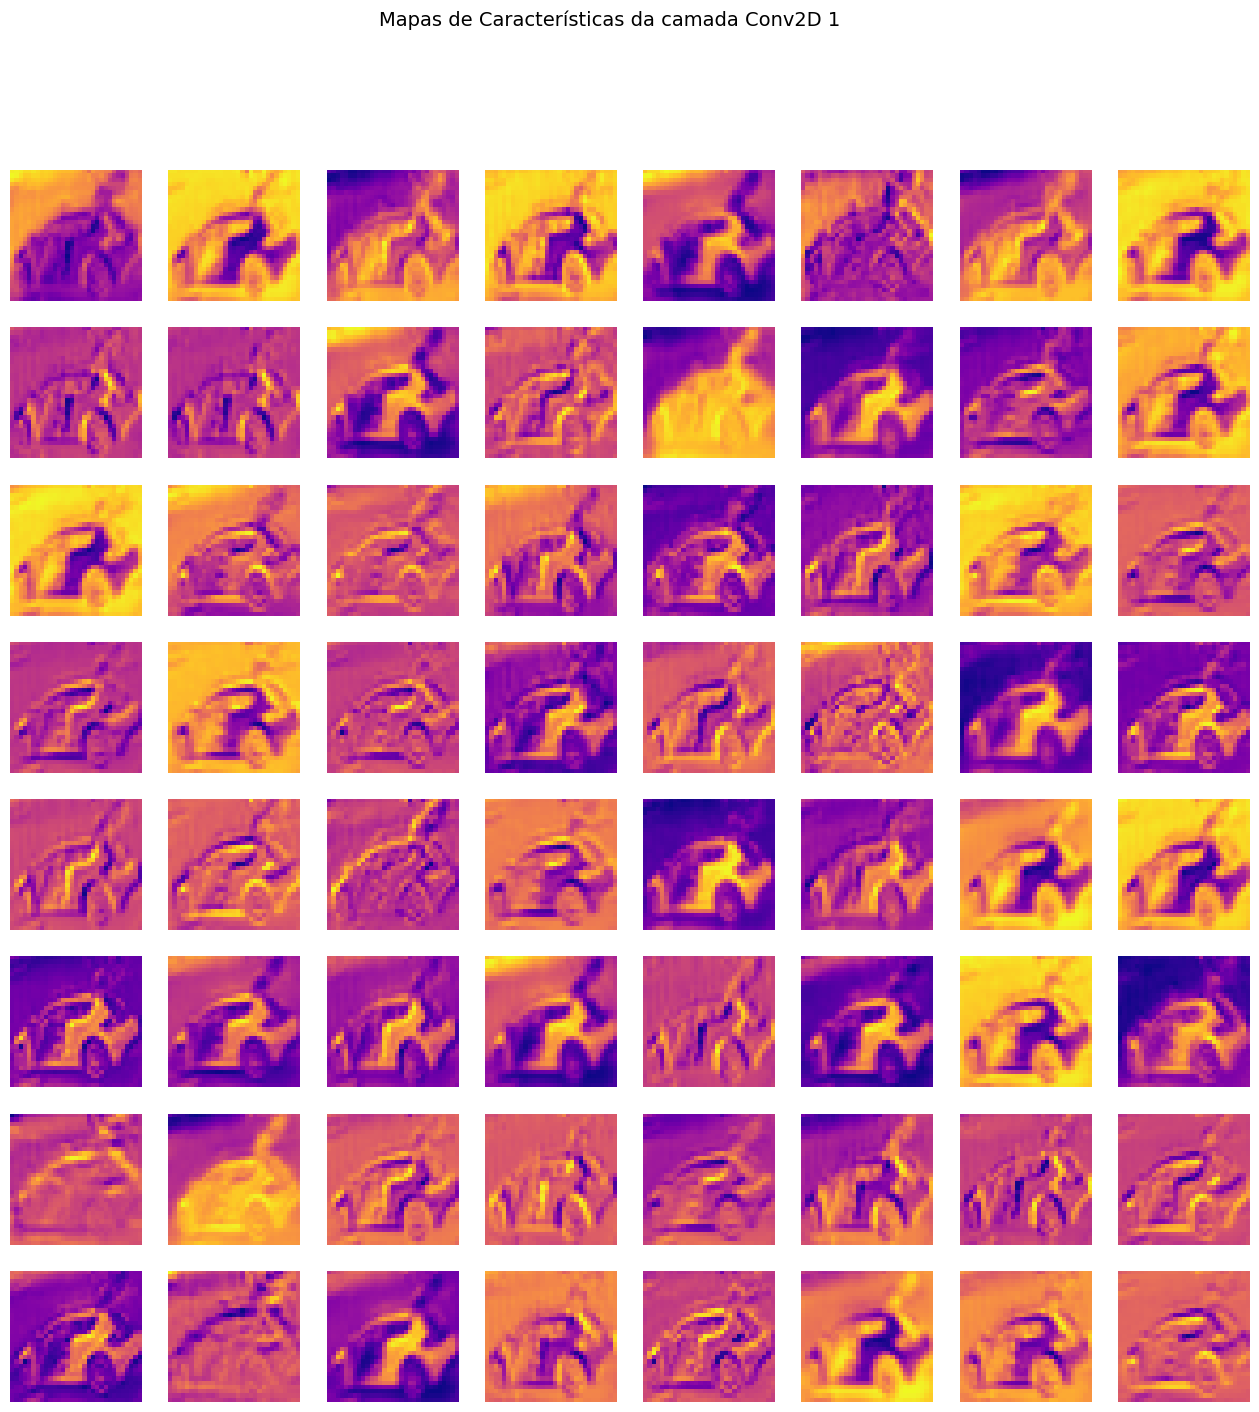

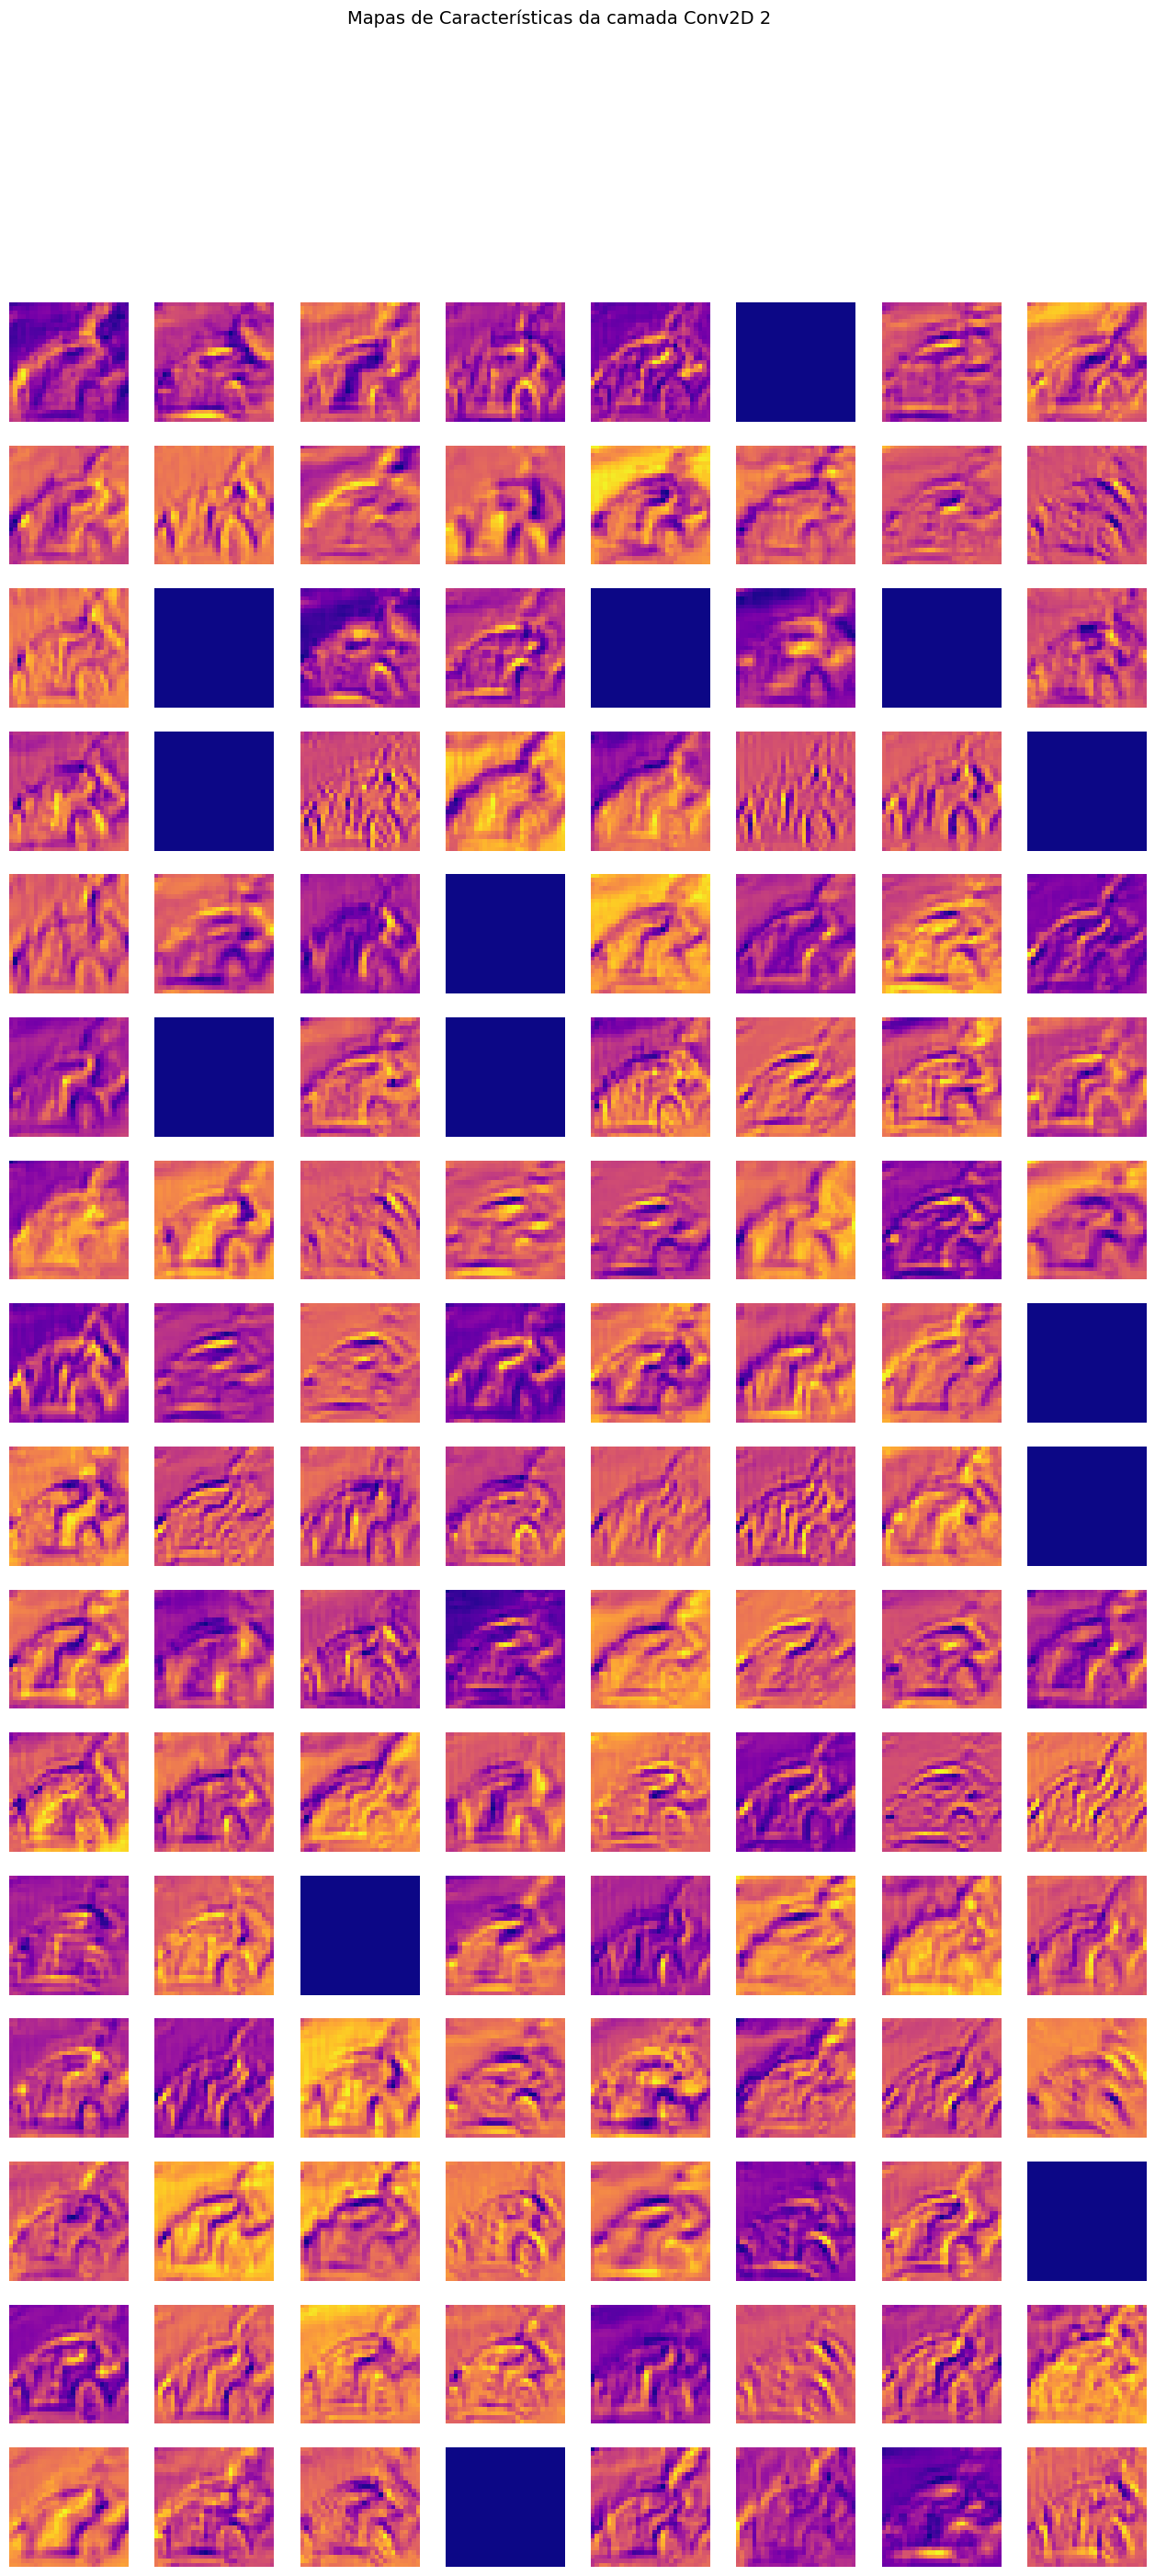

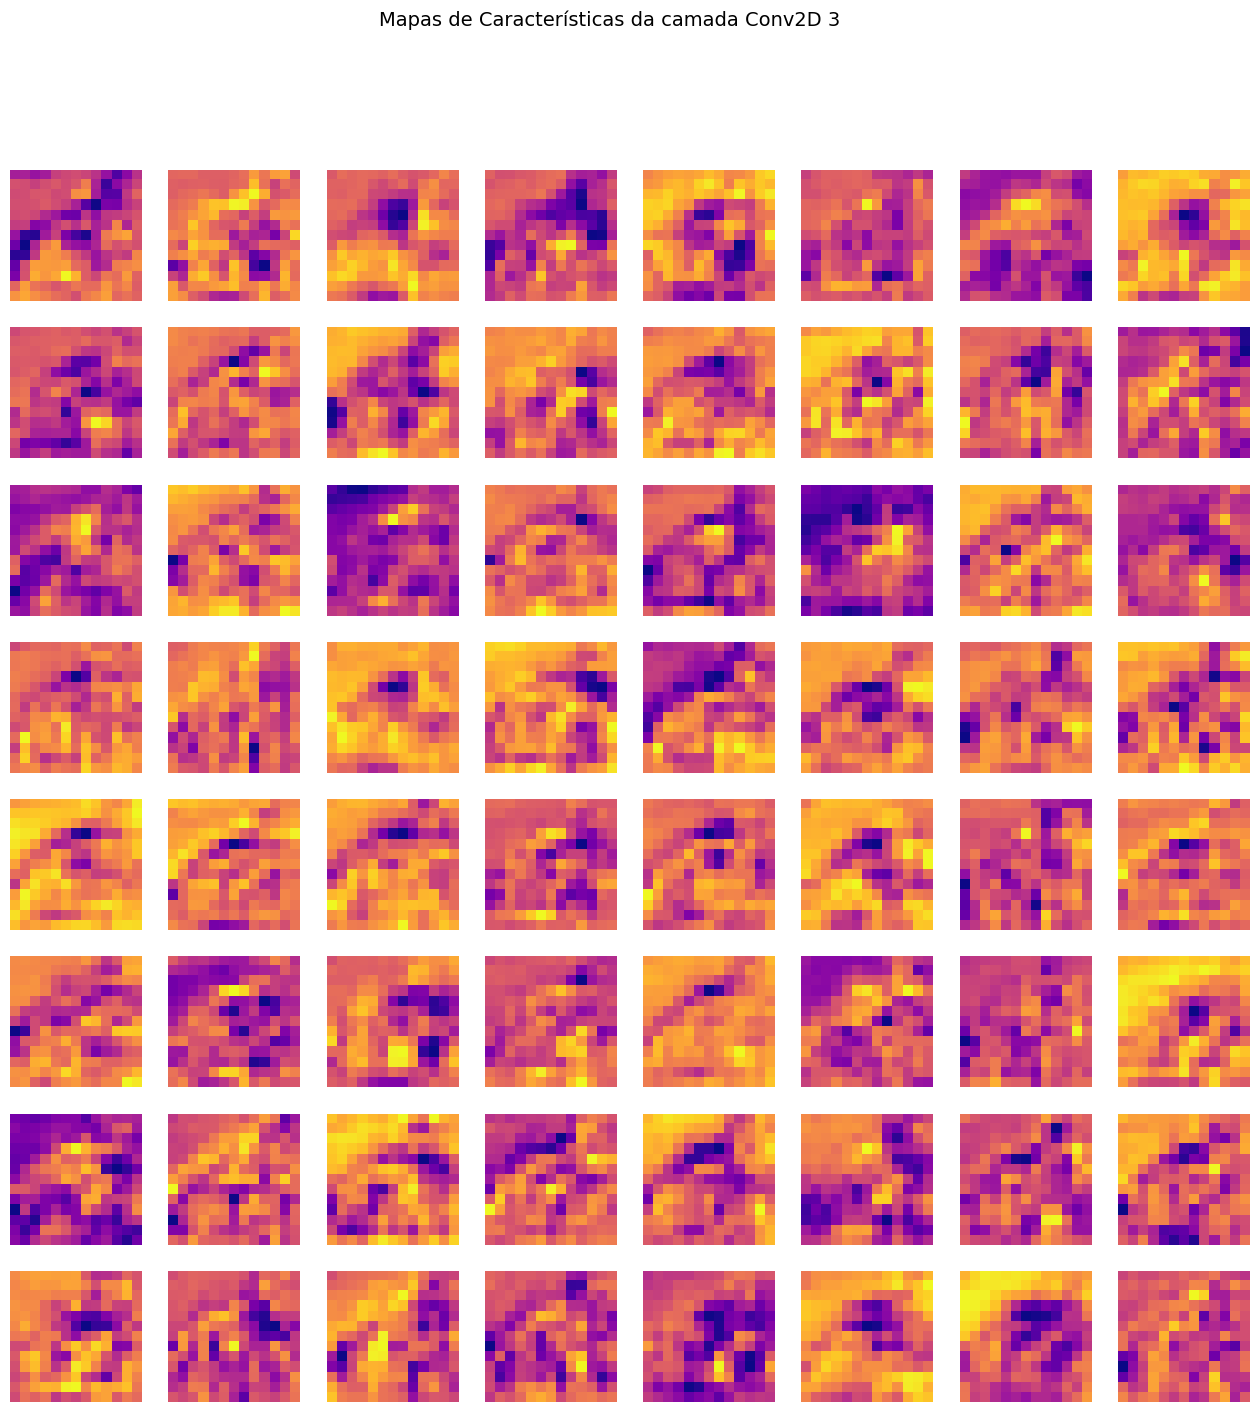

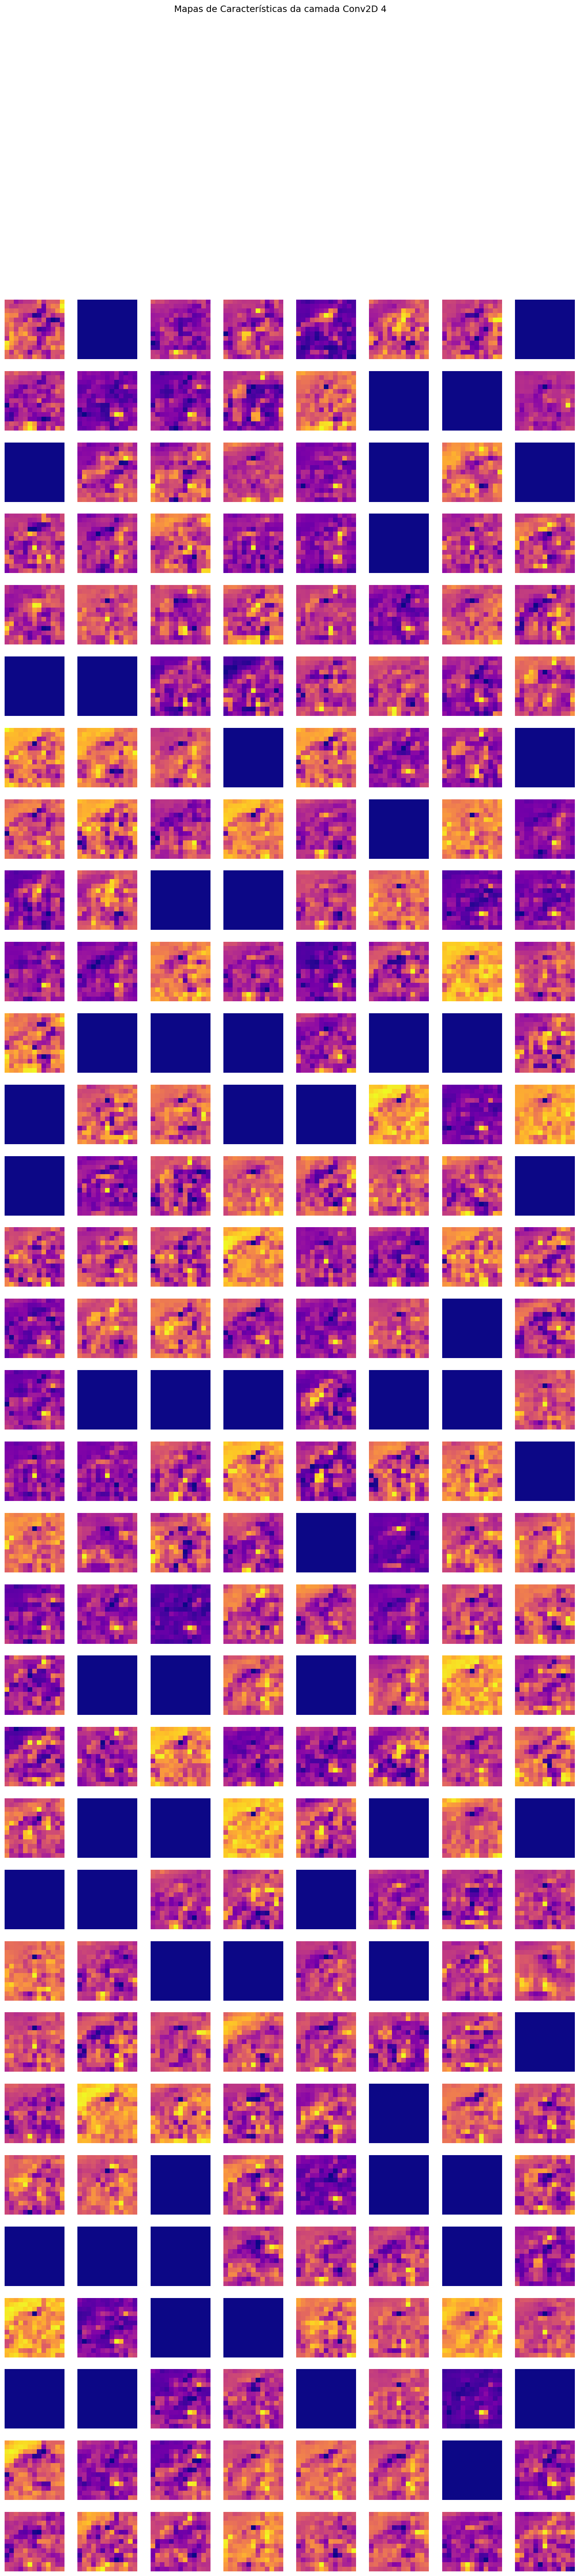

In [24]:
# Acessa as entradas e saídas do modelo
inputs = model.inputs
outputs = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]

# Cria um novo modelo com as saídas das camadas Conv2D
activation_model = Model(inputs=inputs, outputs=outputs)

# Prepara a imagem de teste
img = x_test[6]
img = np.expand_dims(img, axis=0)

# Obtém as ativações das camadas
activations = activation_model.predict(img)

# Visualiza as ativações
for i, activation in enumerate(activations):
    n_features = activation.shape[-1]
    n_cols = min(n_features, 8)  # Define número máximo de colunas como 8
    n_rows = (n_features + n_cols - 1) // n_cols  # Calcula o número de linhas

    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for j in range(n_features):
        plt.subplot(n_rows, n_cols, j+1)
        plt.imshow(activation[0, :, :, j], cmap='plasma')
        plt.axis('off')

    # Título do gráfico
    plt.suptitle(f'Mapas de Características da camada Conv2D {i+1}', fontsize=14)
    plt.show()


In [25]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (128, 32, 32, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (128, 31, 31, 64)           │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (128, 31, 31, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (128, 31, 31, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (128, 29, 29, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (128, 29, 29, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (128, 29, 29, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (128, 14, 14, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (128, 13, 13, 64)           │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (128, 13, 13, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (128, 13, 13, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (128, 13, 13, 256)          │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (128, 13, 13, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (128, 13, 13, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (128, 13, 13, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (128, 43264)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (128, 43264)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (128, 128)                  │       5,537,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (128, 128)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,017,056 (64.91 MB)

 Trainable params: 5,672,010 (21.64 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 11,344,022 (43.27 MB)

# TESTES
Inferencia de imagens externas

Saving carro.jpg to carro.jpg


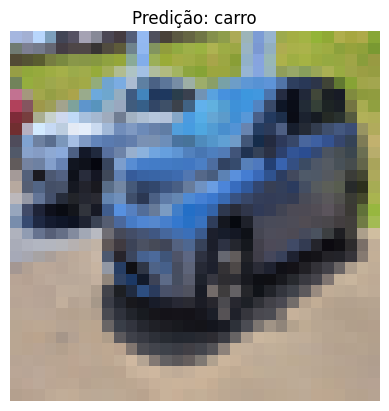

In [26]:
# Upload e predição
def predict_uploaded_image():
    # Upload da imagem
    uploaded = files.upload()

    # Pegar a primeira imagem enviada
    image_path = list(uploaded.keys())[0]

    # Carregar e preparar a imagem
    img = Image.open(image_path)
    img = img.resize((32, 32))
    img_array = np.array(img)
    img_array = img_array.astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Fazer predição
    pred = model.predict(img_array, verbose=0)
    classe = class_names[np.argmax(pred)]

    # Mostrar imagem e resultado
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predição: {classe}')
    plt.show()

# Usar
predict_uploaded_image()